<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Курс "Глубокое обучение". Первый семестр</b></h3>

# Домашнее задание. Сегментация изображений

---


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>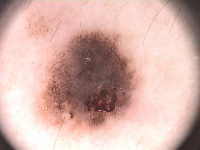</td><td>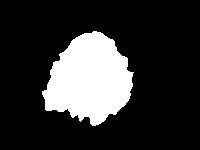</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [63]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2020-12-24 23:41:03--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2020-12-24 23:41:03--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc8659ab5151d4e68d696b5d4c69.dl.dropboxusercontent.com/cd/0/inline/BFugaM_cghAnAuQj2AAxsSDpjl9sJokR3gN4ahYMHDbGo863FtQCGsQKh2GZ2qoZWE5FqmsNC3TaXI6G0ZwDOIzxgb2SL5SyFn69ud-F-4kSGA/file# [following]
--2020-12-24 23:41:03--  https://uc8659ab5151d4e68d696b5d4c69.dl.dropboxusercontent.com/cd/0/inline/BFugaM_cghAnAuQj2AAxsSDpjl9sJokR3gN4ahYMHDbGo863FtQCGsQKh2GZ2qoZWE5FqmsNC3TaXI6G0ZwDOIzxgb2SL5SyFn69ud-F-4kSGA/file
Resolving 

In [64]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [65]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [66]:
images[0].shape

(576, 768, 3)

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [67]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [68]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [69]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

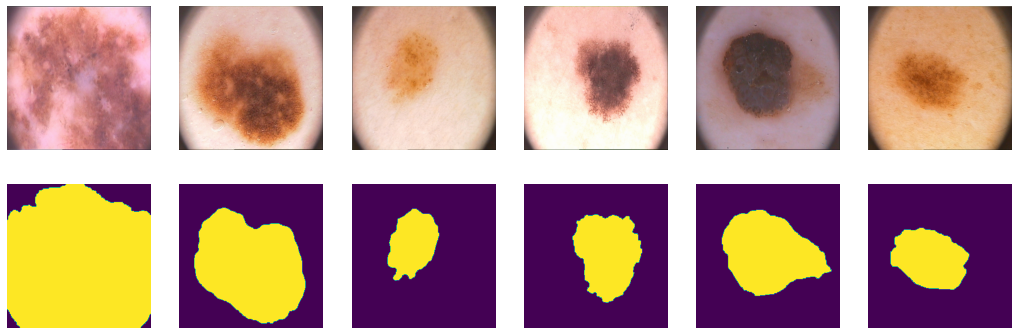

In [70]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [71]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [72]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 10
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [73]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

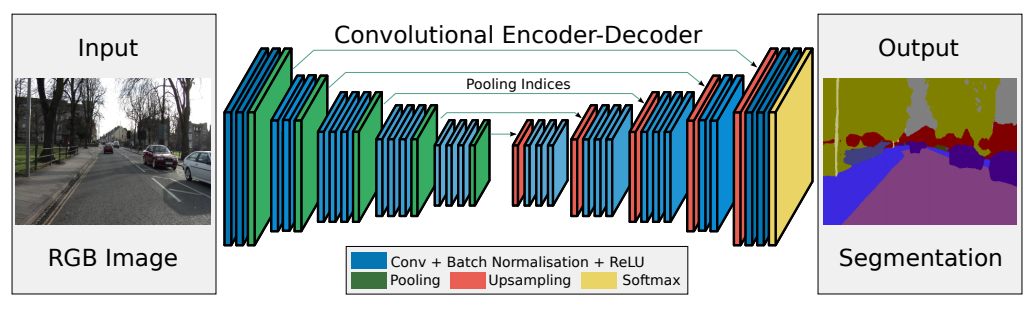

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [75]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.pool0 = nn.MaxPool2d(2,2,return_indices=True)  # 256 -> 128

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.pool1 = nn.MaxPool2d(2,2,return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        self.pool2 = nn.MaxPool2d(2,2,return_indices=True) # 64 -> 32
        
        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())
        self.pool3 = nn.MaxPool2d(2,2,return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1, bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU())

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU())
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU())
        self.upsample2 = nn.MaxUnpool2d(2,2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU())
        self.upsample3 = nn.MaxUnpool2d(2,2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1))

    def forward(self, x):
        x = x.to(device)
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b,ind3))
        d1 = self.dec_conv1(self.upsample1(d0,ind2))
        d2 = self.dec_conv2(self.upsample2(d1,ind1))
        d3 = self.dec_conv3(self.upsample3(d2,ind0)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [76]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [77]:
def bce_loss(y_real, y_pred):
  return torch.mean(y_pred - y_real*y_pred+torch.log(1+torch.exp(-y_pred)))
    # please don't use nn.BCELoss. write it from scratch

In [78]:
#Определим словарь для лосов и score
dic_for_loss = {}
dic_for_score = {}

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [79]:
def train(model, opt, loss_fn, epochs, data_tr, data_val,fordic):
    X_val, Y_val = next(iter(data_val))
    loss_array = []
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) # data to device

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch,Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        loss_array.append(np.asscalar(avg_loss))
        toc = time()

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to("cpu") # detach and put into cpu

        # Visualize tools
   #     clear_output(wait=True)
    dic_for_loss[fordic] = loss_array
    for k in range(6):
      plt.subplot(2, 6, k+1)
      plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
      plt.title('Real')
      plt.axis('off')

      plt.subplot(2, 6, k+7)
      plt.imshow(Y_hat[k, 0], cmap='gray')
      plt.title('Output')
      plt.axis('off')
    plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
    plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [80]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [81]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.sigmoid(model(X_batch))>0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [82]:
model = SegNet().to(device)

In [ ]:
max_epochs = 100
optimizer = optim.Adam(model.parameters())
train(model, optimizer, bce_loss, max_epochs, data_tr, data_val,"SegNet+bce_loss")

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

In [ ]:
dic_for_score["SegNet+bce_loss_val"] = score_model(model, iou_pytorch, data_val)

In [ ]:
dic_for_score["SegNet+bce_loss_tr"] = score_model(model, iou_pytorch, data_tr)

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало, прежде чем бить тревогу попробуйте поперебирать различные варианты, убедитесь, что во всех других сетапах сетть достигает желанного результата. СПОЙЛЕР: учиться она будеет при всех лоссах предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [83]:
def dice_loss(targets, inputs):
    smooth = 1.
    inputs = torch.sigmoid(inputs)
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum() 
    dice = torch.mean((2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth))
    return 1 - dice

Проводим тестирование:

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

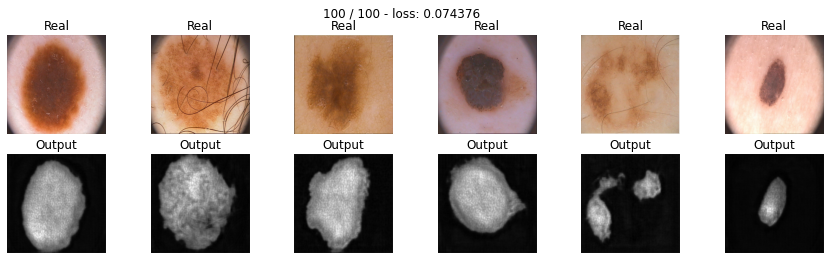

In [84]:
model_dice = SegNet().to(device)
max_epochs = 100
optimaizer = optim.Adam(model_dice.parameters())
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val,"SegNet+dice_loss")

In [85]:
dic_for_score["SegNet+dice_loss_val"] = score_model(model_dice, iou_pytorch, data_val)
dic_for_score["SegNet+dice_loss_tr"] = score_model(model_dice, iou_pytorch, data_tr)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    BCE_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
    pt = torch.exp(-BCE_loss)
    F_loss = (1-pt)**gamma * BCE_loss
    return F_loss.mean()

In [ ]:
model_focal = SegNet().to(device)
max_epochs = 100
optimaizer = optim.Adam(model_focal.parameters())
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val,"SegNet+focal_loss")

In [ ]:
dic_for_score["SegNet+focal_loss_val"] = score_model(model_focal, iou_pytorch, data_val)
dic_for_score["SegNet+focal_loss_tr"] = score_model(model_focal, iou_pytorch, data_tr)

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
def ft_loss(y_true,y_pred,gamma=1,alpha=0.5,betta=0.5,smooth=1):
  inputs = torch.sigmoid(y_pred).view(-1)
  targets = y_true.view(-1)
  #True Positives, False Positives & False Negatives
  TP = torch.sum(inputs * targets)
  FP = torch.sum((1-targets) * inputs)
  FN = torch.sum((targets * (1-inputs)))
  Tversky = (TP + smooth) / (TP + alpha*FP + betta*FN + smooth)  
  return (1 - Tversky)**(gamma)

In [ ]:
model_ft = SegNet().to(device)
max_epochs = 100
optimaizer = optim.Adam(model_ft.parameters())
train(model_ft, optimaizer, ft_loss, max_epochs, data_tr, data_val,"SegNet+ft_loss")

In [ ]:
dic_for_score["SegNet+ft_loss_val"] = score_model(model_ft, iou_pytorch, data_val)
dic_for_score["SegNet+ft_loss_tr"] = score_model(model_ft, iou_pytorch, data_tr)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

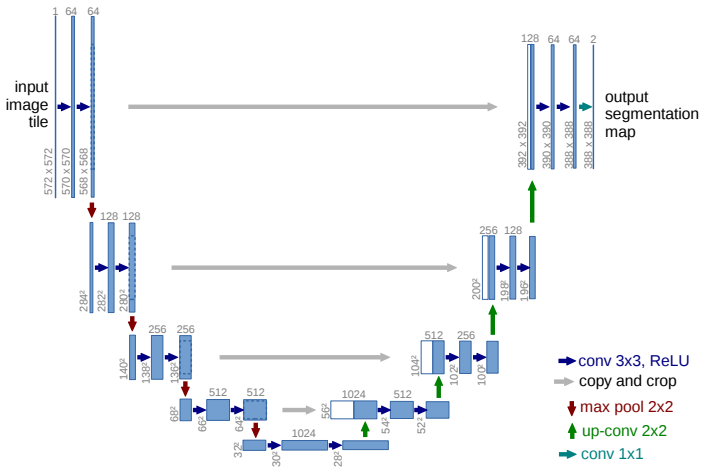

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
def double_conv(in_channels,out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True)
    )
    return conv
    
class UNet(nn.Module):   
      def __init__(self):
        super().__init__()       
        # encoder (downsampling)
        self.max_pool = nn.MaxPool2d(2,2)
        self.enc_conv0 = double_conv(3,64)
        self.enc_conv1 = double_conv(64,128)
        self.enc_conv2 = double_conv(128,256)
        self.enc_conv3 = double_conv(256,512)
        self.enc_conv4 = double_conv(512,1024)
        
        self.up_trans_0 = nn.Upsample(32)
        self.up_trans_1 = nn.Upsample(64)
        self.up_trans_2 = nn.Upsample(128)
        self.up_trans_3 = nn.Upsample(256)


        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1536, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=768, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=192, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dec_conv4 = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1)#out
                                       
      def forward(self, x):
          x = x.to(device)
          # encoder
          e0 = self.enc_conv0(x)
          e0_0 = self.max_pool(e0)
          e1 = self.enc_conv1(e0_0)
          e1_0 = self.max_pool(e1)
          e2 = self.enc_conv2(e1_0)
          e2_0 = self.max_pool(e2)
          e3 = self.enc_conv3(e2_0)
          e3_0 = self.max_pool(e3)
          e4 = self.enc_conv4(e3_0)

          # decoder
          x = self.up_trans_0(e4)
          x = self.dec_conv0(torch.cat((x, e3), 1))
          x = self.up_trans_1(x)
          x = self.dec_conv1(torch.cat((x, e2), 1))
          x = self.up_trans_2(x)
          x = self.dec_conv2(torch.cat((x, e1), 1))
          x = self.up_trans_3(x)
          x = self.dec_conv3(torch.cat((x, e0), 1))
          x = self.dec_conv4(x)
          return x

In [ ]:
unet_model = UNet().to(device)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

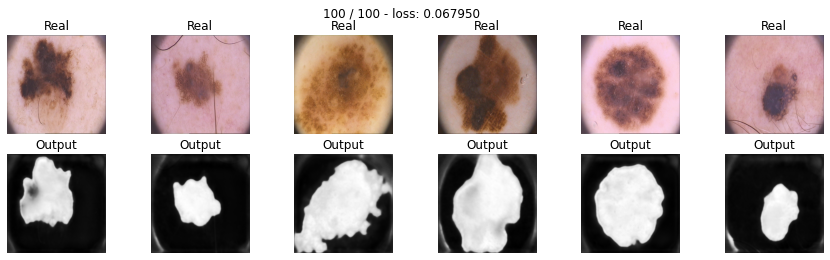

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), dice_loss, 100, data_tr, data_val,"Unet1+dice_loss")

In [ ]:
dic_for_score["UNet1+dice_loss_val"] = score_model(unet_model, iou_pytorch, data_val)
dic_for_score["UNet1+dice_loss_tr"] = score_model(unet_model, iou_pytorch, data_tr)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

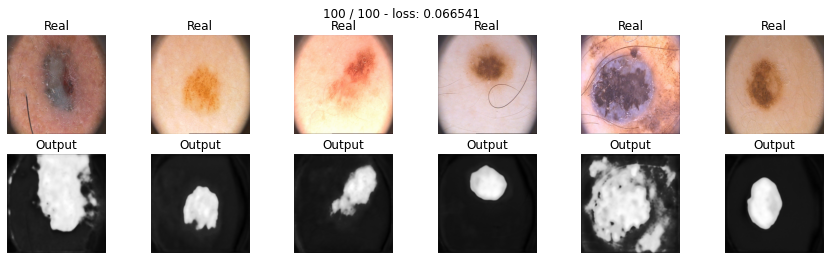

In [ ]:
unet_model = UNet().to(device)
train(unet_model, optim.Adam(unet_model.parameters()), ft_loss, 100, data_tr, data_val,"Unet1+ft_loss")

In [ ]:
dic_for_score["UNet1+ft_loss_val"] = score_model(unet_model, iou_pytorch, data_val)
dic_for_score["UNet1+ft_loss_tr"] = score_model(unet_model, iou_pytorch, data_tr)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

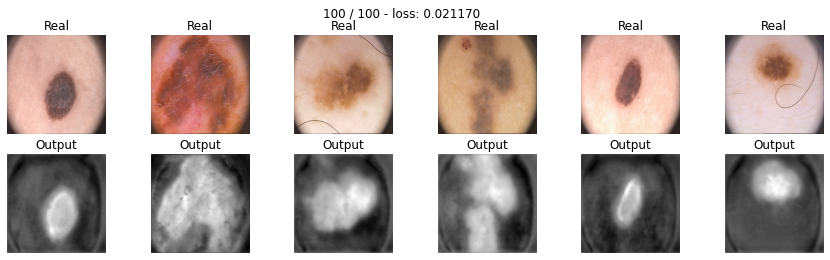

In [ ]:
unet_model = UNet().to(device)
train(unet_model, optim.Adam(unet_model.parameters()), focal_loss, 100, data_tr, data_val,"Unet1+focal_loss")

In [ ]:
dic_for_score["UNet1+focal_loss_val"] = score_model(unet_model, iou_pytorch, data_val)
dic_for_score["UNet1+focal_loss_tr"] = score_model(unet_model, iou_pytorch, data_tr)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

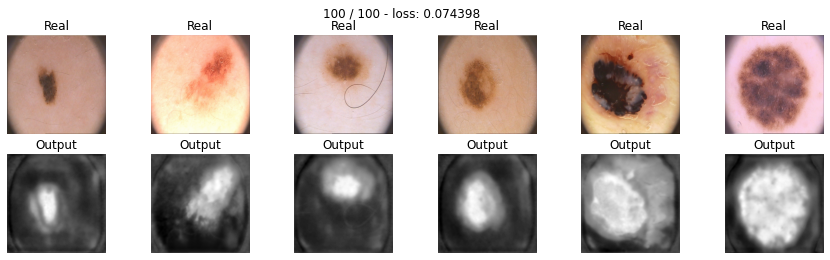

In [ ]:
unet_model = UNet().to(device)
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 100, data_tr, data_val,"Unet1+bce_loss")

In [ ]:
dic_for_score["UNet1+bce_loss_val"] = score_model(unet_model, iou_pytorch, data_val)
dic_for_score["UNet1+bce_loss_tr"] = score_model(unet_model, iou_pytorch, data_tr)

# U-Net2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
def double_conv(in_channels,out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True)
    )
    return conv

def conv(out_channels):
    conv2 = nn.Conv2d(out_channels,out_channels,stride=2,kernel_size=2)
    return conv2

class UNet2(nn.Module):   
      def __init__(self):
        super().__init__()       
        # encoder (downsampling)
        self.enc_conv0 = double_conv(3,64)
        self.enc_conv1 = double_conv(64,128)
        self.enc_conv2 = double_conv(128,256)
        self.enc_conv3 = double_conv(256,512)
        self.enc_conv4 = double_conv(512,1024)
        self.conv0 = conv(64)
        self.conv1 = conv(128)
        self.conv2 = conv(256)
        self.conv3 = conv(512)

        self.up_trans_0 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )

        # decoder (upsampling)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.dec_conv4 = nn.Conv2d(in_channels=64,out_channels=1,kernel_size=1)#out
                                       
      def forward(self, x):
          x = x.to(device)
          # encoder
          e0 = self.enc_conv0(x)
          e0_0 = self.conv0(e0)
          e1 = self.enc_conv1(e0_0)
          e1_0 = self.conv1(e1)
          e2 = self.enc_conv2(e1_0)
          e2_0 = self.conv2(e2)
          e3 = self.enc_conv3(e2_0)
          e3_0 = self.conv3(e3)
          e4 = self.enc_conv4(e3_0)

          # decoder
          x = self.up_trans_0(e4)
          x = self.dec_conv0(torch.cat((x, e3), 1))
          x = self.up_trans_1(x)
          x = self.dec_conv1(torch.cat((x, e2), 1))
          x = self.up_trans_2(x)
          x = self.dec_conv2(torch.cat((x, e1), 1))
          x = self.up_trans_3(x)
          x = self.dec_conv3(torch.cat((x, e0), 1))
          x = self.dec_conv4(x)
          return x

In [ ]:
unet2_model = UNet2().to(device)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

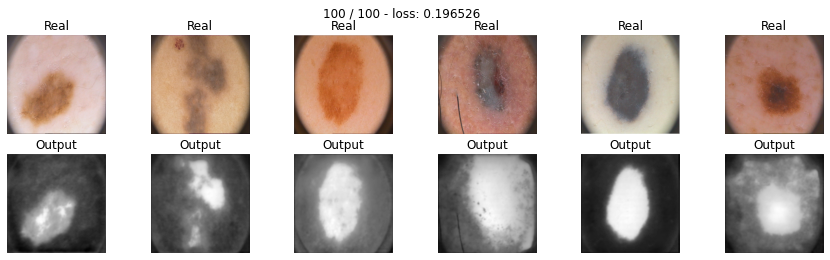

In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 100, data_tr, data_val,"Unet2+bce_loss")

In [ ]:
dic_for_score["UNet2+bce_loss_val"] = score_model(unet2_model, iou_pytorch, data_val)
dic_for_score["UNet2+bce_loss_tr"] = score_model(unet2_model, iou_pytorch, data_tr)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

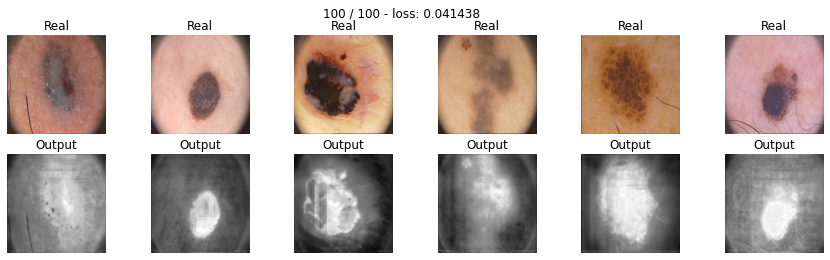

In [ ]:
unet2_model = UNet2().to(device)
train(unet2_model, optim.Adam(unet2_model.parameters()), focal_loss, 100, data_tr, data_val,"Unet2+focal_loss")

In [ ]:
dic_for_score["UNet2+focal_loss_val"] = score_model(unet2_model, iou_pytorch, data_val)
dic_for_score["UNet2+focal_loss_tr"] = score_model(unet2_model, iou_pytorch, data_tr)

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100
* Epoch 47/100
* Epoch 48/100
* Epoch 49/100
* Epoch 50/100
* Epoch 51/100
* Epoch 52/100
* Epoch 53/100
* Epoch 54/100
* Epoch 55/100
* Epoch 56/100
* Epoch 57/100
* Epoch 58/100
* Epoch 59/100
* Epoch 60/100
* Epoch 61/100
* Epoch 62/100
* Epoch 63/100
* Epoch 64/100
* Epoch 65/100
* Epoch 66/100
* Epoch 67/100
* Epoch 68/100
* E

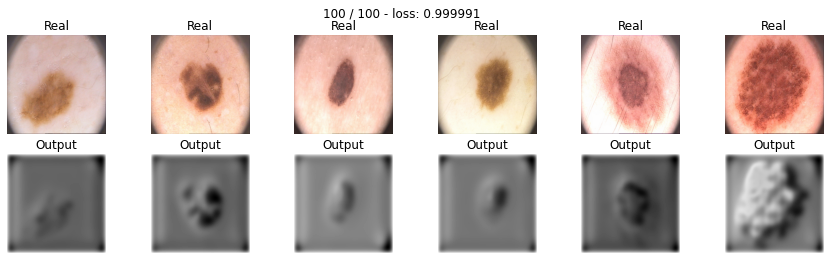

In [ ]:
unet2_model = UNet2().to(device)
train(unet2_model, optim.Adam(unet2_model.parameters()), ft_loss, 100, data_tr, data_val,"Unet2+ft_loss")

In [ ]:
dic_for_score["UNet2+ft_loss_val"] = score_model(unet2_model, iou_pytorch, data_val)
dic_for_score["UNet2+ft_loss_tr"] = score_model(unet2_model, iou_pytorch, data_tr)

In [ ]:
def dice_loss(targets, inputs):
    smooth = 1.
    inputs = torch.sigmoid(inputs)
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    intersection = (inputs * targets).sum() 
    dice = torch.mean((2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth))
    return 1 - dice

In [ ]:
unet2_model = UNet2().to(device)
train(unet2_model, optim.Adam(unet2_model.parameters()), dice_loss, 100, data_tr, data_val,"Unet2+dice_loss")

* Epoch 1/100


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


* Epoch 2/100
* Epoch 3/100
* Epoch 4/100
* Epoch 5/100
* Epoch 6/100
* Epoch 7/100
* Epoch 8/100
* Epoch 9/100
* Epoch 10/100
* Epoch 11/100
* Epoch 12/100
* Epoch 13/100
* Epoch 14/100
* Epoch 15/100
* Epoch 16/100
* Epoch 17/100
* Epoch 18/100
* Epoch 19/100
* Epoch 20/100
* Epoch 21/100
* Epoch 22/100
* Epoch 23/100
* Epoch 24/100
* Epoch 25/100
* Epoch 26/100
* Epoch 27/100
* Epoch 28/100
* Epoch 29/100
* Epoch 30/100
* Epoch 31/100
* Epoch 32/100
* Epoch 33/100
* Epoch 34/100
* Epoch 35/100
* Epoch 36/100
* Epoch 37/100
* Epoch 38/100
* Epoch 39/100
* Epoch 40/100
* Epoch 41/100
* Epoch 42/100
* Epoch 43/100
* Epoch 44/100
* Epoch 45/100
* Epoch 46/100


In [ ]:
dic_for_score["UNet2+dice_loss_val"] = score_model(unet2_model, iou_pytorch, data_val)
dic_for_score["UNet2+dice_loss_tr"] = score_model(unet2_model, iou_pytorch, data_tr)

Сделайте вывод какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

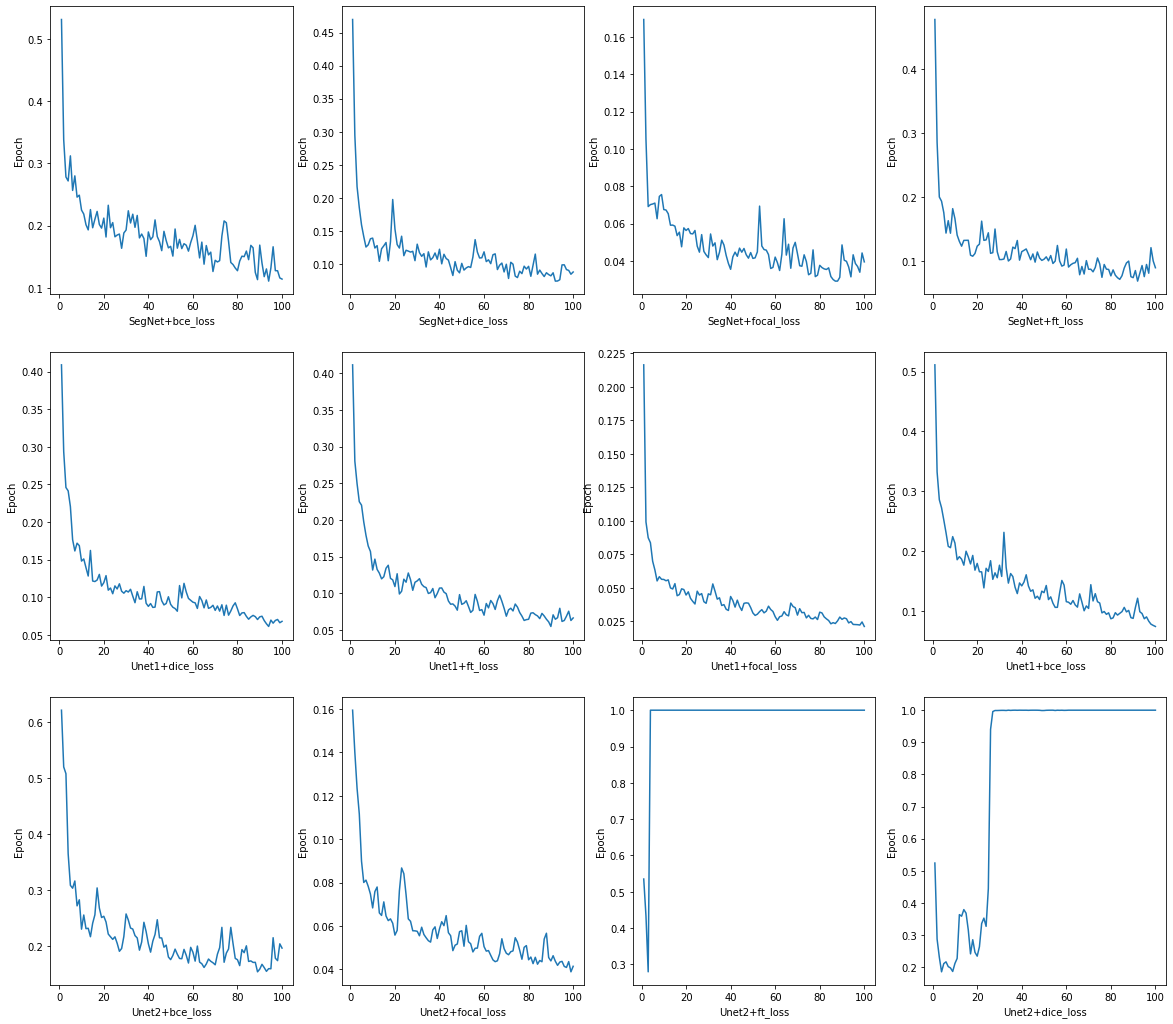

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

label = list(dic_for_loss.keys())
value = list(dic_for_loss.values())
fig, axes = plt.subplots(nrows=3, ncols=4)

n = 0

for ax in axes.flat:
 #   ax.set(title='axes_' + str(n), xticks=[1,2,3], yticks=[3,4,6])
    ax.plot(range(1,101),value[n])
    ax.set_ylabel(label[n])
    ax.set_xlabel("Epoch")
    n += 1

fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(18)    #  высота Figure
plt.show()


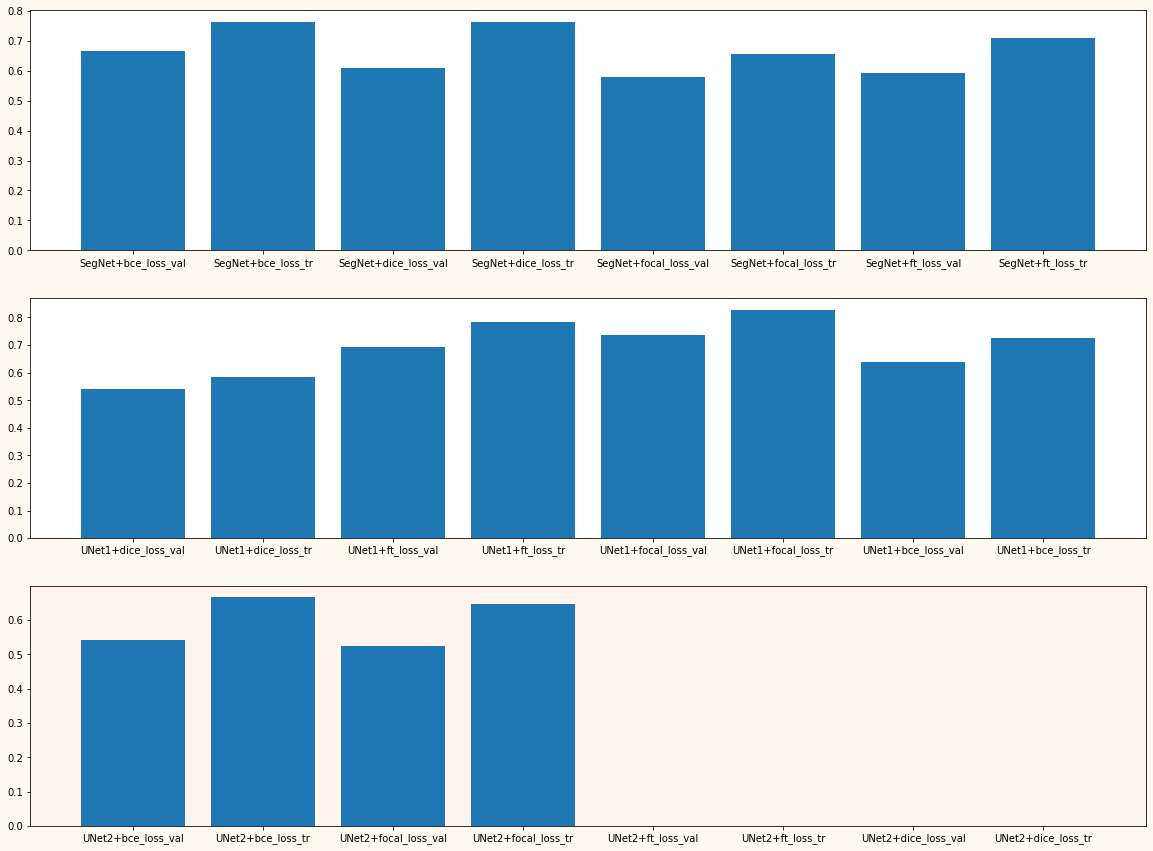

In [ ]:
x = list(dic_for_score.values())
y = list(dic_for_score.keys())
fig, axes = plt.subplots(nrows=3, ncols=1)

n = 0
for ax in axes.flat:
  ax.bar(y[0+n*8:8+n*8], x[0+n*8:8+n*8])
  n += 1
ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(15)    #  высота Figure
plt.show()

In [ ]:
"""
def double_conv(in_channels,out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True)
    )
    return conv.cuda()


def crop_tensor(tensor,target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]

    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[
        :,
        :,
        delta:tensor_size - delta,
        delta:tensor_size - delta
    ]

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.down_conv_1 = double_conv(3,64)
        self.down_conv_2 = double_conv(64,128)
        self.down_conv_3 = double_conv(128,256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512,1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )

        self.up_conv_1 = double_conv(1024,512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )

        self.up_conv_2 = double_conv(512,256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )

        self.up_conv_3 = double_conv(256,128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )

        self.up_conv_4 = double_conv(128,64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self,image):
        # encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        # decoder 
        x = self.up_trans_1(x9)
        print(x.size)
        y = crop_tensor(x7,x)

        x = self.up_conv_1(torch.cat([x,y],axis=1))
        x = self.up_trans_2(x)
        y = crop_tensor(x5,x)
        x = self.up_conv_2(torch.cat([x,y],axis=1))

        x = self.up_trans_3(x)
        y = crop_tensor(x3,x)
        x = self.up_conv_3(torch.cat([x,y],axis=1))

        x = self.up_trans_4(x)
        y = crop_tensor(x1,x)
        x = self.up_conv_4(torch.cat([x,y],axis=1))

        out = self.out(x)

        return out

  def bce_loss(y_real, y_pred):
  loss = nn.BCELoss(reduction="mean")
  return loss(y_real, y_pred)
  """